In [291]:
import pandas as pd 
credentials = pd.read_csv('credentials.csv')
consumer_key = credentials['consumer_key'][0]
consumer_secret = credentials['consumer_secret'][0]
access_token = credentials['access_token'][0]
access_secret = credentials['access_secret'][0]
 
import tweepy
from tweepy import OAuthHandler
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth, wait_on_rate_limit=True)

import warnings
warnings.simplefilter('ignore')

In [303]:
from pymongo import MongoClient
client = MongoClient()
news_tweets = client.tweets_db.new_tweets
tweets_other = client.tweets_db.tweets_other


In [300]:
id = 1013652236159868930

In [304]:
tweets_other.insert_one(tw)

In [306]:
tw = news_tweets.find_one_and_delete({'id':id})
    

In [307]:
tw

In [309]:
tweets_other.count()

3384

In [313]:
user_del_list =  [ 
 u'NBCNews',
 u'BBCWorld'
 u'TIME',
 u'washingtonpost',
 u'news_welle',
 u'CBSNews',
]

In [312]:
user

u'NBCNews'

In [314]:
for user in user_del_list:
    print(user)
    for id in tweets_df[tweets_df['user']==user]['id']:
        tw = news_tweets.find_one_and_delete({'id':id})
        if tw:
            tweets_other.insert_one(tw)

NBCNews
BBCWorldTIME
washingtonpost
news_welle
CBSNews


In [293]:
news_tweets.count()

156343

In [29]:
tweets = api.user_timeline(screen_name = "ABCnews",count=200)

In [9]:
tw = my_tweets[0]

In [315]:
users = api.friends('@amnasri2', count=100)

In [316]:
[u.screen_name for u in users]

[u'NYTSports',
 u'nytimesbusiness',
 u'nytimesarts',
 u'nytimestech',
 u'BBCWorldBiz',
 u'BBCPolitics',
 u'BBCNewsEnts',
 u'BBCSport',
 u'cnnsport',
 u'politico',
 u'CNNPolitics',
 u'business',
 u'FortuneMagazine',
 u'CNNMoney',
 u'CNNent',
 u'HarvardHealth',
 u'NYTHealth',
 u'cnnhealth',
 u'cnntech',
 u'CNET',
 u'rtetwip',
 u'PnPCBC',
 u'NewshubPolitics',
 u'SkyNewsPolitics',
 u'CBSPolitics',
 u'RealClearNews',
 u'foxnewspolitics',
 u'ABCPolitics',
 u'CBCHealth',
 u'CBSHealth',
 u'KHNews',
 u'NBCNewsHealth',
 u'NPRHealth',
 u'bbchealth',
 u'EverydayHealth',
 u'HealthHive',
 u'CBCEnt',
 u'breakingbytes',
 u'FoxNewsTech',
 u'ReutersTech',
 u'BBCTech',
 u'technology',
 u'TechCrunch',
 u'fttechnews',
 u'NBCNewsTech',
 u'ForbesTech',
 u'ETEconomyNews',
 u'ftfinancenews',
 u'FinancialTimes',
 u'TheWeatherNetUS',
 u'bn9weather',
 u'SkyNewsWeather',
 u'HTSportsNews',
 u'NewsdaySports',
 u'FOXSportsNews',
 u'SkySportsNews',
 u'BNNBloomberg',
 u'AM730Traffic']

In [82]:
len(users)

52

Started collecting tweets
Collected 19 tweets in 16.13 seconds
Started collecting tweets
Collected 11 tweets in 15.80 seconds
Started collecting tweets
Collected 29 tweets in 17.40 seconds
Started collecting tweets
Collected 18 tweets in 16.19 seconds
Started collecting tweets
Collected 17 tweets in 16.11 seconds


In [317]:
import time
def collect_tweets(users):
    curr_count = news_tweets.count()
    now = time.time()
    print("Started collecting tweets")
    for user in users:
        #tweets = api.user_timeline(screen_name = user.screen_name, count=200)
        try:
            tweets = tweepy.Cursor(api.user_timeline,screen_name=user.screen_name).items()
        except:
            continue
            
        for tw in tweets:

            if news_tweets.find_one({'id':tw.id}):
                break

            try:
                news_tweets.insert_one(tw._json)
            except DuplicateKeyError:
                break
                
    new_count = news_tweets.count()
    new_time = time.time() - now
    print("Collected %d tweets in %.2f seconds" % (new_count - curr_count, new_time))
    

In [67]:
from threading import Timer

class RepeatedTimer(object):
    def __init__(self, interval):
        self._timer     = None
        self.interval   = interval
        self.is_running = False
        self.start()

    def _run(self):
        collect_tweets(users)
        self.is_running = False
        self.start()
        

    def start(self):
        if not self.is_running:
            self._timer = Timer(self.interval, self._run)
            self._timer.start()
            self.is_running = True

    def stop(self):
        self._timer.cancel()
        self.is_running = False

In [33]:
interval = 15 * 60  # 30 minutes
rt = RepeatedTimer(interval)

In [31]:
rt.stop()

In [318]:
import threading
import time


class MyThread(threading.Thread):
    def __init__(self, interval, task, args=[], kwargs={}):
        super(MyThread, self).__init__()
        self.stop_ = False
        self.interval = interval
        self.args = args
        self.kwargs = kwargs
        self.task = task
        self.start()
        
    def run(self):
        while not self.stop_:
            self.task(*self.args, **self.kwargs)
            time.sleep(self.interval)
            
    def stop(self):
        self.stop_ = True
        
mythread = MyThread(15 * 60, collect_tweets, [users])

Started collecting tweets


In [279]:
mythread.stop()

In [278]:
news_tweets.count()

147423

Collected 21754 tweets in 1681.22 seconds
Started collecting tweets
Collected 21 tweets in 19.63 seconds
Started collecting tweets
Collected 11 tweets in 19.26 seconds
Started collecting tweets
Collected 13 tweets in 19.47 seconds
Started collecting tweets
Collected 15 tweets in 19.15 seconds
Started collecting tweets
Collected 18 tweets in 19.52 seconds
Started collecting tweets
Collected 9 tweets in 19.60 seconds
Started collecting tweets
Collected 21 tweets in 20.23 seconds
Started collecting tweets
Collected 18 tweets in 19.92 seconds
Started collecting tweets
Collected 11 tweets in 19.22 seconds
Started collecting tweets
Collected 14 tweets in 19.69 seconds


In [89]:
#news_tweets.drop()

In [2]:
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin
import re
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        comments_clean = []
        for c in X:
            c = c.replace('\\\\', '\\')
            c = c.replace('\\n', ' ')
            #c = c.replace('\'', '')
            c = re.sub(r'[-_"]', '', c)
            c = re.sub(r'[*%&,?!;]', ' ', c)
            c = re.sub(r"(.)\1{2,}", '\g<1>', c)
            c = re.sub(r'\.(\s+|$)', ' ', c)
            c = re.sub(r'[^\x00-\x7F]+',' ', c)
            #c = re.sub(r'@[^ ]*', ' ', c)
            #c = re.sub(r'[0-9]+', ' ', c)
            c = re.sub(r'https?://[\w./]+', ' ', c)
            c = [wordnet_lemmatizer.lemmatize(wordnet_lemmatizer.lemmatize(w, pos='v')).lower() 
                          for w in c.split()]
            c = " ".join(w for w in c if len(w) > 2)
            #c = " ".join([w.lower() for w in c.split()])# if 3<=len(w)<=40])
            comments_clean.append(c)
        return comments_clean

prep = Preprocessor()

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.corpus import stopwords

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.5, max_features=10000,
                             min_df=2, stop_words='english', token_pattern=u'((?u)\\b\\w\\w+\\b|[#@]\w+)',
                             use_idf=True)

tf_vectorizer = CountVectorizer(ngram_range=(1, 2), max_df=0.5, max_features=10000,
                             min_df=2, stop_words='english', token_pattern=u'((?u)\\b\\w\\w+\\b|[#@]\w+)'
                             )

In [281]:
tw = news_tweets.find().next()

u'CBCHealth'

In [285]:
tweets_df = pd.DataFrame([[tw['id'], tw['text'], tw['user']['screen_name']] 
                           for tw in news_tweets.find()], columns=['id', 'text', 'user'])


In [288]:
tweets_df['user'].value_counts()

CNN                3384
NBCNews            3370
washingtonpost     3367
abcnews            3356
TIME               3342
ABC                3339
CBSNews            3336
HTSportsNews       3305
TechCrunch         3290
ForbesTech         3287
EverydayHealth     3286
BBCWorld           3283
cbcnewsbc          3283
FinancialTimes     3281
CTVVancouver       3270
GlobalBC           3264
FoxNewsTech        3255
CBCEnt             3250
bn9weather         3249
RealClearNews      3248
AM730Traffic       3247
TheWeatherNetUS    3247
BNNBloomberg       3244
NewsdaySports      3241
SkySportsNews      3241
ftfinancenews      3235
foxnewspolitics    3235
FOXSportsNews      3230
fttechnews         3228
NewshubPolitics    3228
ETEconomyNews      3224
CBSPolitics        3224
CBSHealth          3223
CBCVancouver       3222
KHNews             3220
bbchealth          3220
technology         3220
NBCNewsHealth      3218
CBCHealth          3217
ABCPolitics        3216
NPRHealth          3216
SkyNewsWeather  

In [290]:
tweets_df[tweets_df['user']=='BBCTech']

,id,text,user
34882,1013558464050814981,NHS app: Will it cut down on wasted appointmen...,BBCTech
34883,1013207549468868613,Hi-tech dreamcatcher defeats sleep amnesia htt...,BBCTech
34884,1012855093866135553,Fortnite: A fortnight in my 40s in Battle Roya...,BBCTech
34885,1012850212044451840,AI to help tackle fake news in Mexican electio...,BBCTech
34886,1012792517169999877,Apple Maps: Grand plan to fix iPhone Maps app ...,BBCTech
34887,1012724629453058048,Tech Tent: Facebook's drone falls to earth htt...,BBCTech
34888,1012651242873647104,Legal bid to throw out US sex trafficking law ...,BBCTech
34889,1012645120611704832,Floating robot Cimon sent to International Spa...,BBCTech
34890,1012633058229604352,Fake bookings hit Singapore's Ryde Technologie...,BBCTech
34891,1012632063521054720,RT @matthew_wall: How would you make meetings ...,BBCTech


In [4]:
import numpy as np

In [5]:
tweets_id = np.array([tw['id'] for tw in news_tweets.find()])
tweets_text = np.array([tw['text'] for tw in news_tweets.find()])
tweets_text_processed = prep.fit_transform(tweets_text)
#tweets_text_vec = tfidv_vectorizer.fit_transform(text_processed)
#tweets_text_count_vec = count_vectorizer.fit_transform(text_processed)

In [48]:
"""

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)

stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

def lemmatize_stemming(text, stem=True):
    result = lemmatizer.lemmatize(text, pos='v')
    if stem:
        result = stemmer.stem(result)
    return result
    
def preprocess(text):
    
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS \
            and len(token) > 3 and len(token) < 40 \
            and token.isalpha:
            result.append(lemmatize_stemming(token, stem=False))
    return " ".join(result)


from sklearn.datasets import fetch_20newsgroups

#dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = [preprocess(tw['text']) for tw in news_tweets.find()]
"""

'\n\nimport gensim\nfrom gensim.utils import simple_preprocess\nfrom gensim.parsing.preprocessing import STOPWORDS\nfrom nltk.stem import WordNetLemmatizer, SnowballStemmer\nfrom nltk.stem.porter import *\nimport numpy as np\nnp.random.seed(2018)\n\nstemmer = SnowballStemmer(\'english\')\nlemmatizer = WordNetLemmatizer()\n\ndef lemmatize_stemming(text, stem=True):\n    result = lemmatizer.lemmatize(text, pos=\'v\')\n    if stem:\n        result = stemmer.stem(result)\n    return result\n    \ndef preprocess(text):\n    \n    result = []\n    for token in gensim.utils.simple_preprocess(text):\n        if token not in gensim.parsing.preprocessing.STOPWORDS             and len(token) > 3 and len(token) < 40             and token.isalpha:\n            result.append(lemmatize_stemming(token, stem=False))\n    return " ".join(result)\n\n\nfrom sklearn.datasets import fetch_20newsgroups\n\n#dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=(\'headers\', \'footers\', \'quotes\'

In [37]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

def display_topics(model, feature_names, no_top_words):
    nmf_lables = nmf.transform(tfidf).argmax(axis=1)

    for topic_idx, topic in enumerate(model.components_):
        n_tweets = np.sum(nmf_lables == topic_idx)
        print "Topic %d: %d tweets" % (topic_idx, n_tweets)
        print " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
        print
        

no_features = 1000
no_topics = 50

# Data cleaning



# NMF is able to use tf-idf
#tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(tweets_text_processed)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf.fit(tfidf)

"""
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
#tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(tweets_text_processed)
tf_feature_names = tf_vectorizer.get_feature_names()

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=15, learning_method='online', learning_decay=.9, learning_offset=50.,random_state=0)
lda.fit(tf)
"""

no_top_words = 20
display_topics(nmf, tfidf_feature_names, no_top_words)
#display_topics(lda, tf_feature_names, no_top_words)

Topic 0: 6329 tweets
forecast weather weather forecast watch evening weather watch evening evening @skynewsnaz forecast @skynewsnaz latest weather watch latest friday weather watch friday latest friday tuesday weather watch tuesday saturday weather watch saturday thursday weather
Topic 1: 15979 tweets
china bank trade deal tech canada big company market fund billion share buy war hit raise investment tariff government india
Topic 2: 1558 tweets
twitter live twitter watch starting miss live @markets twitter miss @markets live starting @markets #cheddarlive miss watch twitter watch @cheddar @cheddar live watch #cheddarlive starting @cheddar tap tap watch tune
Topic 3: 2783 tweets
health mental mental health insurance health insurance health news public health health care yahoo public @khnews health law law health risk health canada health official women gop kaiser affect
Topic 4: 3635 tweets
trump president president trump donald donald trump trump say kim kim jong jong administration pr

In [28]:
display_topics(nmf, tfidf_feature_names, no_top_words)


Topic 0: 6329 tweets
forecast weather weather forecast watch evening weather watch evening evening @skynewsnaz forecast @skynewsnaz latest weather watch latest friday weather watch friday latest friday tuesday weather watch tuesday saturday weather watch saturday thursday weather

Topic 1: 15979 tweets
china bank trade deal tech canada big company market fund billion share buy war hit raise investment tariff government india

Topic 2: 1558 tweets
twitter live twitter watch starting miss live @markets twitter miss @markets live starting @markets #cheddarlive miss watch twitter watch @cheddar @cheddar live watch #cheddarlive starting @cheddar tap tap watch tune

Topic 3: 2783 tweets
health mental mental health insurance health insurance health news public health health care yahoo public @khnews health law law health risk health canada health official women gop kaiser affect

Topic 4: 3635 tweets
trump president president trump donald donald trump trump say kim kim jong jong administratio

In [32]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=1,
            verbose=True)
km.fit(tfidf)

Initialization complete
Iteration  0, inertia 255495.799
Iteration  1, inertia 130696.686
Iteration  2, inertia 130388.295
Iteration  3, inertia 130259.859
Iteration  4, inertia 130109.731
Iteration  5, inertia 130080.017
Iteration  6, inertia 130055.986
Iteration  7, inertia 130032.591
Iteration  8, inertia 130014.591
Iteration  9, inertia 130010.805
Iteration 10, inertia 130010.388
Iteration 11, inertia 130010.146
Iteration 12, inertia 130009.425
Iteration 13, inertia 130008.381
Iteration 14, inertia 130008.125
Iteration 15, inertia 130008.107
Iteration 16, inertia 130008.089
Iteration 17, inertia 130008.073
Iteration 18, inertia 130008.064
Iteration 19, inertia 130008.055
Iteration 20, inertia 130008.044
Iteration 21, inertia 130008.034
Iteration 22, inertia 130008.008
Iteration 23, inertia 130007.973
Iteration 24, inertia 130007.901
Iteration 25, inertia 130007.681
Iteration 26, inertia 130007.176
Iteration 27, inertia 130006.994
Iteration 28, inertia 130006.986
Iteration 29, inert

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=10, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=True)

In [33]:
clusters = {}
tweet_index = np.arange(len(tweets_text))
for center in range(km.n_clusters):
    clusters[center] = tweet_index[km.labels_ == center]

    

In [42]:
for i in range(km.n_clusters):
    print(" ".join(np.array(tfidf_vectorizer.get_feature_names())[tfidf[clusters[i]].sum(axis=0).argsort().tolist()[0][-20:]]))
    print

make news sources health billion confirm sky big world manager trade win sign #ssn tech company warn deal china breaking

treatment skin cancer risk know morning forward help day woman year people say risk breast cancer breast like look like cancer come look

friday latest watch friday friday weather watch latest latest weather today forecast @skyisobel @skyisobel watch today today weather forecast @skynewsnaz @skynewsnaz evening watch evening evening weather watch weather forecast weather forecast

@mikeclay wind story morning expect warm weather live sunny big juli watch marquez juli marquez high shower rain day amp today

tap twitter bloomberg starting @markets bloomberg @technology live bloomberg technology @cheddar live @technology @cheddar miss twitter watch #cheddarlive @markets live twitter miss @markets starting watch live twitter live twitter

trump new jersey launch jersey drug announce rule city report year new zealand zealand apple health say study new study new york york 

In [8]:
import pandas as pd
from sklearn.cluster import SpectralClustering
sample_tweets = pd.Series(tweets_text_processed).sample(30000)
tf = tf_vectorizer.fit_transform(sample_tweets)
corr = tf.dot(tf.T)


In [ ]:
sc = SpectralClustering(affinity='precomputed')
sc.fit(corr)

/usr/local/lib/python2.7/dist-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [131]:
metrics.silhouette_score?

In [36]:
n_tweet = tfidf.shape[0]
from sklearn import metrics
metrics.silhouette_score(tfidf, np.random.randint(10, size=(n_tweet)), metric='euclidean', sample_size=int(0.15 * tfidf.shape[0]))


-0.0012257220108786726

In [43]:
import gc

In [47]:
gc.collect()

9

In [46]:
metrics.calinski_harabaz_score(tfidf.toarray(), np.random.randint(10, size=(n_tweet)))  


1.0071915884758484

In [ ]:
sample = np.

In [48]:
metrics.calinski_harabaz_score(tfidf.toarray(), nmf_lables)

MemoryError: 

In [23]:
from sklearn import metrics
kmeans_lables = km.labels_
metrics.silhouette_score(tfidf, kmeans_lables, metric='euclidean', sample_size=int(0.15 * tfidf.shape[0]))


0.0006725186065137529

In [19]:
from sklearn import metrics
nmf_lables = nmf.transform(tfidf).argmax(axis=1)
metrics.silhouette_score(tfidf, nmf_lables, metric='euclidean', sample_size=int(0.15 * tfidf.shape[0]))


-0.019575675851550005

In [17]:
from sklearn import metrics
lda_lables = lda.transform(tf).argmax(axis=1)
metrics.silhouette_score(tf, lda_lables, metric='euclidean', sample_size=int(0.1 * tf.shape[0]))


-0.01753037973604478

In [33]:
tfidf_trans.shape

(50242, 20)

In [42]:
documents = np.array(documents)

In [25]:
tfidf = tfidf_vectorizer.fit_transform(tweets_text_processed)
tfidf_trans = nmf.transform(tfidf)

for topic, top_tweet in enumerate(tfidf_trans.argsort(axis=0)[-10:].T):
    print("topic %d:" % topic)
    for tw in top_tweet:
        print(tweets_text[tw], tweets_text_processed[tw])
    print
    print
    

topic 0:
(u'WATCH The Evening Weather Forecast https://t.co/R659lmIqMs', u'watch the evening weather forecast')
(u'WATCH Evening Weather Forecast https://t.co/qyavr9egkI', u'watch evening weather forecast')
(u'WATCH Evening Weather Forecast https://t.co/5eWQ613btQ', u'watch evening weather forecast')
(u'WATCH Evening Weather Forecast https://t.co/u0sDf7aAQg', u'watch evening weather forecast')
(u'WATCH Evening Weather Forecast https://t.co/ZiXIBgJeSH', u'watch evening weather forecast')
(u'WATCH Evening Weather Forecast https://t.co/goTrF7B19i', u'watch evening weather forecast')
(u'WATCH The Evening Weather Forecast https://t.co/7MgmPVGFnu', u'watch the evening weather forecast')
(u'WATCH Evening Weather Forecast https://t.co/M41zgdXp69', u'watch evening weather forecast')
(u'WATCH The Evening Weather Forecast https://t.co/I9gy54unOI', u'watch the evening weather forecast')
(u'WATCH Evening Weather Forecast https://t.co/qSSXq8p46G', u'watch evening weather forecast')


topic 1:
(u'Thi

In [100]:
nmf.components_.shape

(1, 10000)

In [104]:
type(tfidf)

scipy.sparse.csr.csr_matrix

In [103]:
from scipy.spatial.distance import cdist
n_compnents_list = range(2, 11)
inertia = np.zeros(len(n_compnents_list))
for i, n_components in enumerate(n_compnents_list):
    nmf = NMF(n_components=n_components, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
    #tfidf_trans = nmf.transform(tfidf).argmax(axis=1)
    #centeroids = nmf.components_[tfidf_trans]
    inertia[i] = sum(np.min(cdist(np.array(tfidf), nmf.components_, 'euclidean'), axis=1)) / X.shape[0]


ValueError: XA must be a 2-dimensional array.

In [9]:
import gc

In [11]:
gc.collect()

9

In [18]:
i

12

In [21]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

tfidf = tfidf_vectorizer.fit_transform(tweets_text_processed)

n_compnents_list = range(1, 5) + range(5, 101, 5)
N = 10000
inertia = np.zeros(len(n_compnents_list))
for i, n_components in enumerate(n_compnents_list):
    nmf = NMF(n_components=n_components, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
    tfidf_trans = nmf.transform(tfidf).argmax(axis=1)
    for j in range(tfidf.shape[0]/N+1):
        centeroids = nmf.components_[tfidf_trans[j* N : (j+1)*N]]
        inertia[i] += np.sum(np.array(tfidf[j* N : (j+1)*N] - centeroids)**2)
    inertia[i] /= tfidf.shape[0]
    print(inertia[i])
    gc.collect()

106.49422629003186
145.90248300604395
142.0990577201488
134.08227502699341
130.1154504484397
105.41161167036684
94.2708190647544
87.5593587479236
78.42152612651941
78.75663630364899
65.38470274979358
71.54629034877355
65.08328636445574
62.37824161130139
59.985429827092965
58.03311357686433
55.87978054163262
55.20680949402814
53.328683234907075
54.30538485367143
52.189404424825476
52.28693906057919
50.260926235932516
49.6787383058521


In [24]:
import matplotlib.pyplot as plt
plt.plot(n_compnents_list, inertia);
plt.grid(True)

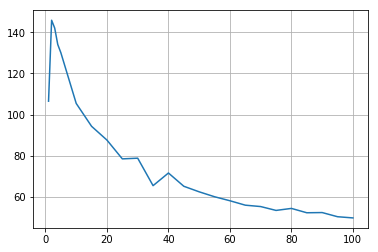

In [25]:
plt.show()

In [66]:

def predict_cluster(tweet_text):
    tweets_text_processed = prep.fit_transform(tweet_text)
    tfidf = tfidf_vectorizer.transform(tweets_text_processed)
    nmf_components = nmf.transform(tfidf)
    nmf_lables = nmf_components.argmax(axis=1)
    print(nmf_components.sum())
    return sorted(nmf_components[0], reverse=True)[:5]


In [39]:
tweets_text[0:1]

array([u"She's 89, deaf and suffering from dementia. Is the busy care system isolating her further? https://t.co/O49eQt02ZP https://t.co/72SN3it2to"],
      dtype='<U156')

In [61]:
text = u'President Trump could invite Kim Jong Un to Mar-a-Lago for follow-up summit: official https://t.co/cQtW76957F'


In [67]:
predict_cluster([text])

0.08676606370436071


[0.04869959142681163, 0.03803818559604331, 2.8286681505783057e-05, 0.0, 0.0]

In [60]:
from pymongo import MongoClient
import json
from tweepy import Stream
from tweepy.streaming import StreamListener
import numpy as np

class MyListener(StreamListener):
 
    def on_data(self, data):
        global cnt
        try:
            tweet = json.loads(data)
            #tweets_collection.insert_one(tweet)
            text = tweet['text']
            print(text, predict_cluster([text]))
            cnt += 1
            if cnt % 1000 == 0:
                print(cnt)
            if cnt == max_count:
                twitter_stream.disconnect()
                print("done!")
                
        except BaseException as e:
            print("Error on_data: %s" % str(e))
        return True
 
    def on_error(self, status):
        print(status)
        return True

#client = MongoClient()
#tweets_collection = client.tweets_db.tweets

cnt = 0
max_count = 100
twitter_stream = Stream(auth=auth, listener=MyListener())
GEOBOX_US_CANADA = [-128.755117, 26.415893, -52.437305, 54.093165]
twitter_stream.filter(locations=GEOBOX_US_CANADA, async=True)
client.close()

(u'@SportsCenter @wojespn Now This is the addition LA needed. A \u201cproven\u201d PG who can distribute and drop dimes to James\u2026 https://t.co/94PtwtpFoA', [0.024657690522807342, 0.00010677272750391116, 0.0, 0.0, 0.0])
(u'Nakakakilig yung MarNigo @MissMarisRacal @ImPascualInigo \U0001f60d\U0001f60d\U0001f60d\U0001f60d #TWBAMariStellar', [0.0, 0.0, 0.0, 0.0, 0.0])
(u'\u201c90210\u201d \U0001f31e\U0001f334 https://t.co/DgooJQ7BRg', [0.0, 0.0, 0.0, 0.0, 0.0])
(u'Well other people that weren\u2019t military children lol', [0.04333330670839242, 0.028974032627738622, 0.0, 0.0, 0.0])
(u'Preview of my latest project... I foresee something amazing!! #fixerupper #painted #smalltown #elkriver @ Painted https://t.co/XgEAWNhqMd', [0.0009995732222980332, 0.0009855645179060108, 0.0007012085471454119, 0.0003583227129240908, 0.0])
(u'#GOPComplicit \n#GOPCorruption https://t.co/oKWAaEAjq6', [0.0, 0.0, 0.0, 0.0, 0.0])
(u"If you're looking for work in #Covina, CA, check out this #job: https://t.co/Z7

In [53]:
twitter_stream.disconnect()


Error on_data: 'inplace' is an invalid keyword argument for this function
